In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_pickle("freqai_df_10d.pkl")

# drop NaNs
df = df.dropna()

df.head()

,date,open,high,low,close,volume,bb_lowerband-period_3_BTC/USD_5m,bb_middleband-period_3_BTC/USD_5m,bb_upperband-period_3_BTC/USD_5m,bb_lowerband-period_5_BTC/USD_5m,bb_middleband-period_5_BTC/USD_5m,bb_upperband-period_5_BTC/USD_5m,bb_lowerband-period_7_BTC/USD_5m,bb_middleband-period_7_BTC/USD_5m,bb_upperband-period_7_BTC/USD_5m,bb_lowerband-period_9_BTC/USD_5m,bb_middleband-period_9_BTC/USD_5m,bb_upperband-period_9_BTC/USD_5m,bb_lowerband-period_10_BTC/USD_5m,bb_middleband-period_10_BTC/USD_5m,bb_upperband-period_10_BTC/USD_5m,bb_lowerband-period_12_BTC/USD_5m,bb_middleband-period_12_BTC/USD_5m,bb_upperband-period_12_BTC/USD_5m,bb_lowerband-period_15_BTC/USD_5m,bb_middleband-period_15_BTC/USD_5m,bb_upperband-period_15_BTC/USD_5m,bb_lowerband-period_20_BTC/USD_5m,bb_middleband-period_20_BTC/USD_5m,bb_upperband-period_20_BTC/USD_5m,bb_lowerband-period_3_BTC/USD_15m,bb_middleband-period_3_BTC/USD_15m,bb_upperband-period_3_BTC/USD_15m,bb_lowerband-period_5_BTC/USD_15m,bb_middleband-period_5_BTC/USD_15m,bb_upperband-period_5_BTC/USD_15m,bb_lowerband-period_7_BTC/USD_15m,bb_middleband-period_7_BTC/USD_15m,bb_upperband-period_7_BTC/USD_15m,bb_lowerband-period_9_BTC/USD_15m,bb_middleband-period_9_BTC/USD_15m,bb_upperband-period_9_BTC/USD_15m,bb_lowerband-period_10_BTC/USD_15m,bb_middleband-period_10_BTC/USD_15m,bb_upperband-period_10_BTC/USD_15m,bb_lowerband-period_12_BTC/USD_15m,bb_middleband-period_12_BTC/USD_15m,bb_upperband-period_12_BTC/USD_15m,bb_lowerband-period_15_BTC/USD_15m,bb_middleband-period_15_BTC/USD_15m,bb_upperband-period_15_BTC/USD_15m,bb_lowerband-period_20_BTC/USD_15m,bb_middleband-period_20_BTC/USD_15m,bb_upperband-period_20_BTC/USD_15m,bb_lowerband-period_3_BTC/USD_1h,bb_middleband-period_3_BTC/USD_1h,bb_upperband-period_3_BTC/USD_1h,bb_lowerband-period_5_BTC/USD_1h,bb_middleband-period_5_BTC/USD_1h,bb_upperband-period_5_BTC/USD_1h,bb_lowerband-period_7_BTC/USD_1h,bb_middleband-period_7_BTC/USD_1h,bb_upperband-period_7_BTC/USD_1h,bb_lowerband-period_9_BTC/USD_1h,bb_middleband-period_9_BTC/USD_1h,bb_upperband-period_9_BTC/USD_1h,bb_lowerband-period_10_BTC/USD_1h,bb_middleband-period_10_BTC/USD_1h,bb_upperband-period_10_BTC/USD_1h,bb_lowerband-period_12_BTC/USD_1h,bb_middleband-period_12_BTC/USD_1h,bb_upperband-period_12_BTC/USD_1h,bb_lowerband-period_15_BTC/USD_1h,bb_middleband-period_15_BTC/USD_1h,bb_upperband-period_15_BTC/USD_1h,bb_lowerband-period_20_BTC/USD_1h,bb_middleband-period_20_BTC/USD_1h,bb_upperband-period_20_BTC/USD_1h,bb_lowerband-period_3_BTC/USD_12h,bb_middleband-period_3_BTC/USD_12h,bb_upperband-period_3_BTC/USD_12h,bb_lowerband-period_5_BTC/USD_12h,bb_middleband-period_5_BTC/USD_12h,bb_upperband-period_5_BTC/USD_12h,bb_lowerband-period_7_BTC/USD_12h,bb_middleband-period_7_BTC/USD_12h,bb_upperband-period_7_BTC/USD_12h,bb_lowerband-period_9_BTC/USD_12h,bb_middleband-period_9_BTC/USD_12h,bb_upperband-period_9_BTC/USD_12h,bb_lowerband-period_10_BTC/USD_12h,bb_middleband-period_10_BTC/USD_12h,bb_upperband-period_10_BTC/USD_12h,bb_lowerband-period_12_BTC/USD_12h,bb_middleband-period_12_BTC/USD_12h,bb_upperband-period_12_BTC/USD_12h,bb_lowerband-period_15_BTC/USD_12h,bb_middleband-period_15_BTC/USD_12h,bb_upperband-period_15_BTC/USD_12h,bb_lowerband-period_20_BTC/USD_12h,bb_middleband-period_20_BTC/USD_12h,bb_upperband-period_20_BTC/USD_12h,bb_lowerband-period_3_BTC/USD_1d,bb_middleband-period_3_BTC/USD_1d,bb_upperband-period_3_BTC/USD_1d,bb_lowerband-period_5_BTC/USD_1d,bb_middleband-period_5_BTC/USD_1d,bb_upperband-period_5_BTC/USD_1d,bb_lowerband-period_7_BTC/USD_1d,bb_middleband-period_7_BTC/USD_1d,bb_upperband-period_7_BTC/USD_1d,bb_lowerband-period_9_BTC/USD_1d,bb_middleband-period_9_BTC/USD_1d,bb_upperband-period_9_BTC/USD_1d,bb_lowerband-period_10_BTC/USD_1d,bb_middleband-period_10_BTC/USD_1d,bb_upperband-period_10_BTC/USD_1d,bb_lowerband-period_12_BTC/USD_1d,bb_middleband-period_12_BTC/USD_1d,bb_upperband-period_12_BTC/USD_1d,bb_lowerband-period_15_BTC/USD_1d,bb_middleband-period_15_BTC/USD

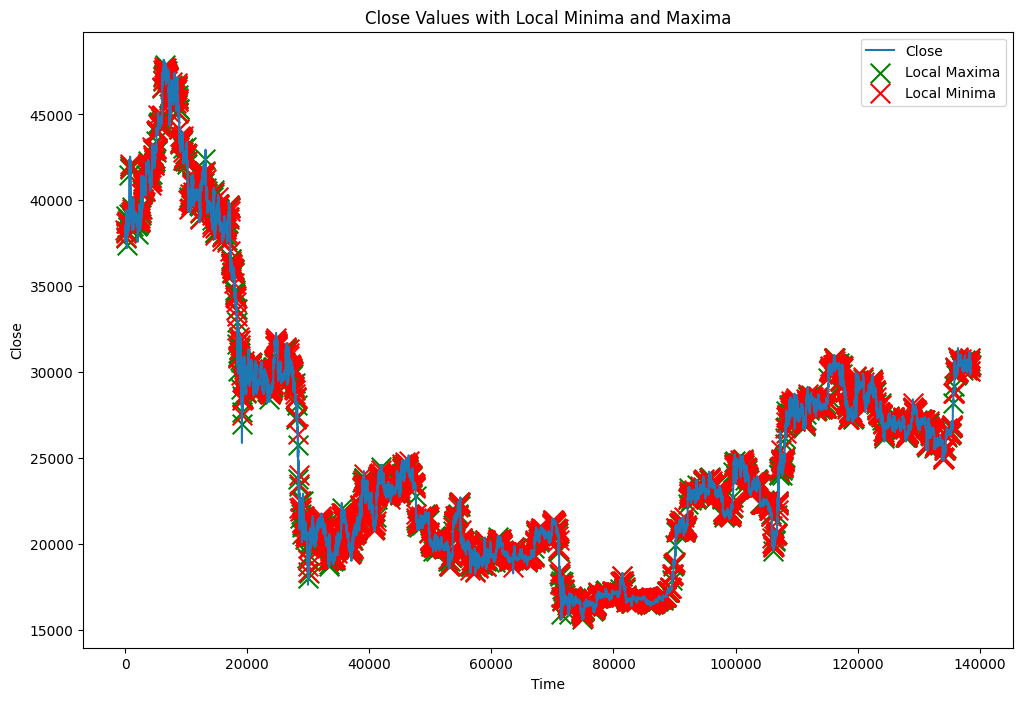

In [4]:
# plot extrema from df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


order=24
# Find local maxima and minima indices
maxima_indices = argrelextrema(df['close'].values, np.greater, order=order)[0]
minima_indices = argrelextrema(df['close'].values, np.less, order=order)[0]

df['exit_max'] = df.index.isin(maxima_indices)
df['enter_min'] = df.index.isin(minima_indices)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df['close'], label='Close')
ax.scatter(df.index[df['exit_max']], df['close'][df['exit_max']], marker='x', color='green', s=200, label='Local Maxima')
ax.scatter(df.index[df['enter_min']], df['close'][df['enter_min']], marker='x', color='red', s=200, label='Local Minima')

ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.set_title('Close Values with Local Minima and Maxima')
ax.legend()
plt.show()


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def analyze_trading_strategy(df, initial_capital=1000.0, use_predicted_values=False, predicted_values: pd.Series=None, use_percentage_capital=True, investment_percentage=0.1, fixed_position_size=100.0, trading_fee_percent=0.002, order=12, plot_flag=True, print_flag=True):
    # Initialize variables
    capital = initial_capital
    has_bought = False
    buy_price = 0.0
    total_profit = 0.0
    trade_profits = []
    trade_profits_pct = []
    peak_capital = initial_capital
    max_drawdown = 0.0
    max_drawdown_pct = 0.0
    total_trades = 0
    winning_trades = 0

    df.reset_index(drop=True, inplace=True)

    if use_predicted_values:
        if isinstance(predicted_values, pd.DataFrame):
            predicted_values.reset_index(drop=True, inplace=True)
            df.loc[(predicted_values['extrema'].values == 'sell'), 'exit_max'] = 1
            df.loc[(predicted_values['extrema'].values == 'buy'), 'enter_min'] = 1
            # count number of signals
            buy_signals = df['enter_min'].sum()
            sell_signals = df['exit_max'].sum()
            print(f"Buy signals: {buy_signals} Sell signals: {sell_signals} Candles: {len(df)}")

        else:
            maxima_indices = np.where(predicted_values == 'sell')[0]
            minima_indices = np.where(predicted_values == 'buy')[0]
            df['exit_max'] = 0
            df['enter_min'] = 0
            df.loc[maxima_indices, 'exit_max'] = 1
            df.loc[minima_indices, 'enter_min'] = 1


    else:
        maxima_indices = argrelextrema(df['close'].values, np.greater, order=order)[0]
        minima_indices = argrelextrema(df['close'].values, np.less, order=order)[0]
        df["exit_max"] = df.index.isin(maxima_indices)
        df["enter_min"] = df.index.isin(minima_indices)
    

    buy_signals = df['enter_min'].sum()
    sell_signals = df['exit_max'].sum()
    
    if plot_flag:
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot the 'close' values
        ax.plot(df['close'], label='Close')
        if use_predicted_values:
            ax.scatter(df.index[df['exit_max'] == 1], df['close'][df['exit_max'] == 1], marker='v', color='orange', s=50, label='Sell')
            ax.scatter(df.index[df['enter_min'] == 1], df['close'][df['enter_min'] == 1], marker='^', color='blue', s=50, label='Buy')
        else:
            ax.scatter(df.index[df['exit_max']], df['close'][df['exit_max']], marker='v', color='red', s=50, label='Local Maxima')
            ax.scatter(df.index[df['enter_min']], df['close'][df['enter_min']], marker='^', color='green', s=50, label='Local Minima')

        ax.set_xlabel('Time')
        ax.set_ylabel('Close')
        ax.set_title('Close Values with Local Minima and Maxima')
        ax.legend()
        plt.show()

    for i in range(len(df)):
        if df.loc[df.index[i], 'enter_min'] == 1 and not has_bought:
            buy_price = df.loc[df.index[i], 'close']
            investment = capital * investment_percentage if use_percentage_capital else min(fixed_position_size, capital)
            buy_fee = investment * trading_fee_percent
            capital -= (investment + buy_fee)
            buy_amount = investment / buy_price
            has_bought = True

        elif df.loc[df.index[i], 'exit_max'] == 1 and has_bought:
            sell_price = df.loc[df.index[i], 'close']
            sell_amount = sell_price * buy_amount
            sell_fee = sell_amount * trading_fee_percent
            sell_amount -= sell_fee
            profit = sell_amount - investment
            profit_pct = (sell_amount/investment-1)*100
            capital += sell_amount
            trade_profits.append(profit)
            trade_profits_pct.append(profit_pct)
            total_trades += 1
            if profit > 0:
                winning_trades += 1
            has_bought = False
            peak_capital = max(peak_capital, capital)
            max_drawdown = max(max_drawdown, peak_capital - capital)
            max_drawdown_pct = max(max_drawdown_pct, (1-capital/peak_capital)*100)

    # Compute additional metrics
    win_percentage = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    average_return = np.mean(trade_profits) if trade_profits else 0
    average_return_pct = np.mean(trade_profits_pct) if trade_profits_pct else 0
    std_deviation = np.std(trade_profits) if trade_profits else 0
    sharpe_ratio = average_return / std_deviation if std_deviation != 0 else 0

    if print_flag:
        print(f"Ending Capital: {capital}")
        print(f"Total Theoretical Profit: {capital - initial_capital}")
        print(f"Win Percentage: {win_percentage}%")
        print(f"Max Drawdown: {max_drawdown}")
        print(f"Max Drawdown Percent: {max_drawdown_pct}")
        print(f"Total Trades: {total_trades}")
        print(f"Average Return: {average_return}")
        print(f"Average Return pct: {average_return_pct}")
        print(f"Sharpe Ratio: {sharpe_ratio}")
        print(f"Buy signals: {buy_signals} Sell signals: {sell_signals} Candles: {len(df)}")
        print(f"Percent of candles with signal (buy or sell): {(buy_signals+sell_signals)/len(df)*100}%")

    return (capital - initial_capital, (buy_signals+sell_signals)/len(df)*100)

In [ ]:
# Define the range of orders to test
order_range = range(1, 480)

# Initialize variables
max_profit = float('-inf')
max_profit_order = None
max_signal_percentage = 0.0
max_signal_percentage_order = None

for order in order_range:
    # Call the analyze_trading_strategy function
    profit, signal_percentage = analyze_trading_strategy(df, order=order, plot_flag=False, print_flag=False)

    # Check if the current order produces a higher profit
    if profit > max_profit:
        max_profit = profit
        max_profit_order = order

    # Check if the current order produces a higher signal percentage
    if signal_percentage > max_signal_percentage:
        max_signal_percentage = signal_percentage
        max_signal_percentage_order = order

print(f"Most profitable order: {max_profit_order} (Profit: {max_profit})")
print(f"Highest signal percentage order: {max_signal_percentage_order} (Signal Percentage: {max_signal_percentage}%)")

Analysis for 5-minute data with order 100:


/var/folders/6t/25gxwxc96x72twpkb7_rjsh00000gn/T/ipykernel_59883/3316287887.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["exit_max"] = df.index.isin(maxima_indices)
/var/folders/6t/25gxwxc96x72twpkb7_rjsh00000gn/T/ipykernel_59883/3316287887.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["enter_min"] = df.index.isin(minima_indices)


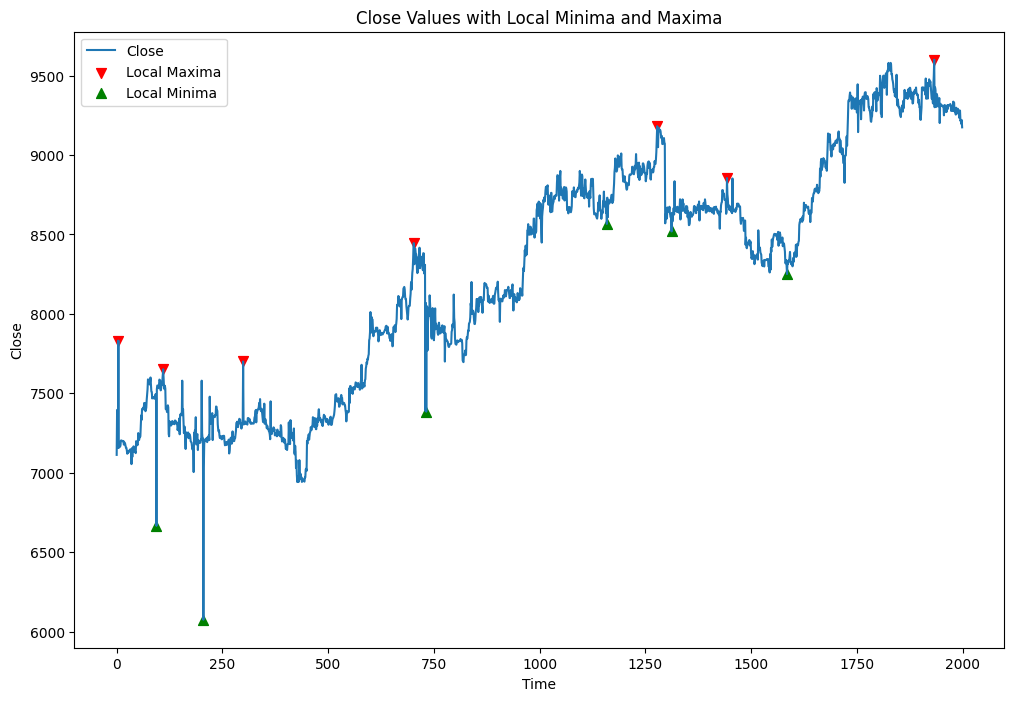

Ending Capital: 1086.686544731197
Total Theoretical Profit: 86.68654473119705
Win Percentage: 100.0%
Max Drawdown: 0.0
Max Drawdown Percent: 0.0
Total Trades: 5
Average Return: 17.544946750687355
Average Return pct: 16.99748743346894
Sharpe Ratio: 2.1376776416954852
Buy signals: 6 Sell signals: 7 Candles: 2000
Percent of candles with signal (buy or sell): 0.65%

Analysis for 5-minute data with order 50:


/var/folders/6t/25gxwxc96x72twpkb7_rjsh00000gn/T/ipykernel_59883/3316287887.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["exit_max"] = df.index.isin(maxima_indices)
/var/folders/6t/25gxwxc96x72twpkb7_rjsh00000gn/T/ipykernel_59883/3316287887.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["enter_min"] = df.index.isin(minima_indices)


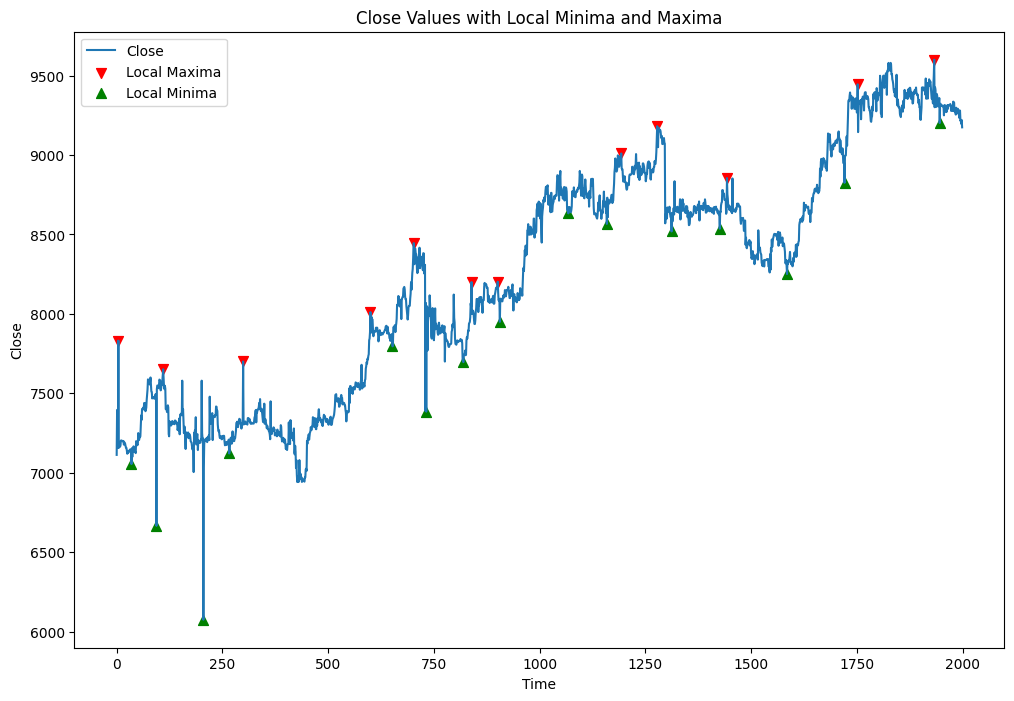

Ending Capital: 977.3920963266124
Total Theoretical Profit: -22.60790367338757
Win Percentage: 100.0%
Max Drawdown: 0.0
Max Drawdown Percent: 0.0
Total Trades: 7
Average Return: 12.526879440017256
Average Return pct: 12.108734957112164
Sharpe Ratio: 1.8517011450072371
Buy signals: 15 Sell signals: 12 Candles: 2000
Percent of candles with signal (buy or sell): 1.35%

Analysis for 5-minute data with order 6:


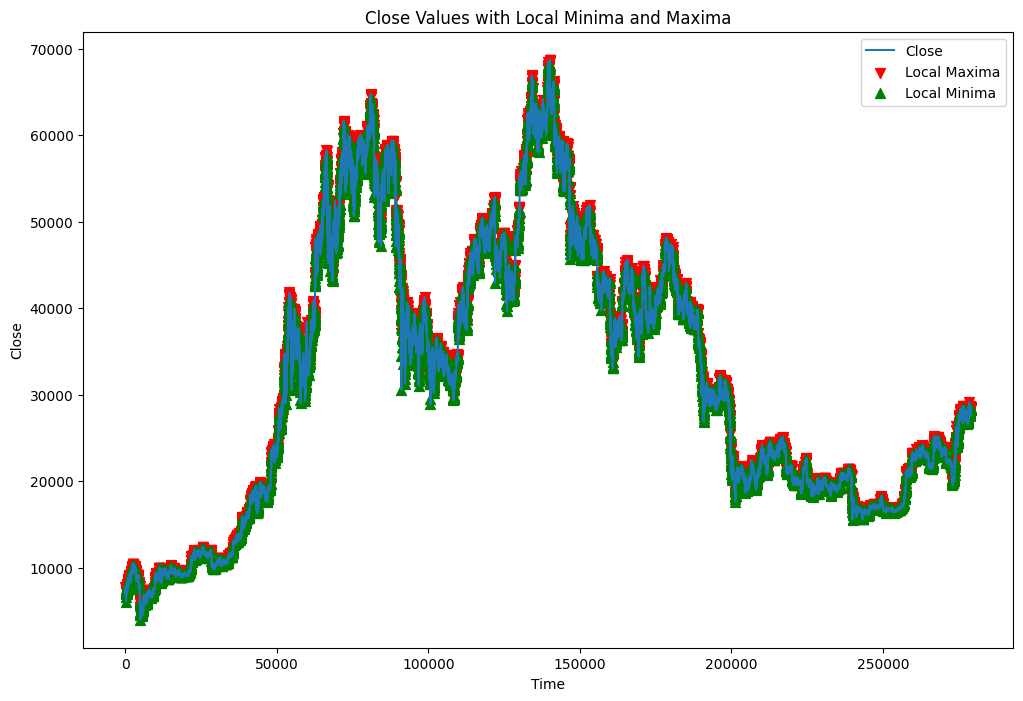

Ending Capital: 1273249.3949968577
Total Theoretical Profit: 1272249.3949968577
Win Percentage: 91.20423108218063%
Max Drawdown: 58169.106108793756
Max Drawdown Percent: 5.036237033561486
Total Trades: 12290
Average Return: 190.35971292365252
Average Return pct: 0.7911155389272349
Sharpe Ratio: 0.4033155195118338
Buy signals: 14862 Sell signals: 14957 Candles: 279014
Percent of candles with signal (buy or sell): 10.68727734092196%

Analysis for 5-minute data with order 24:


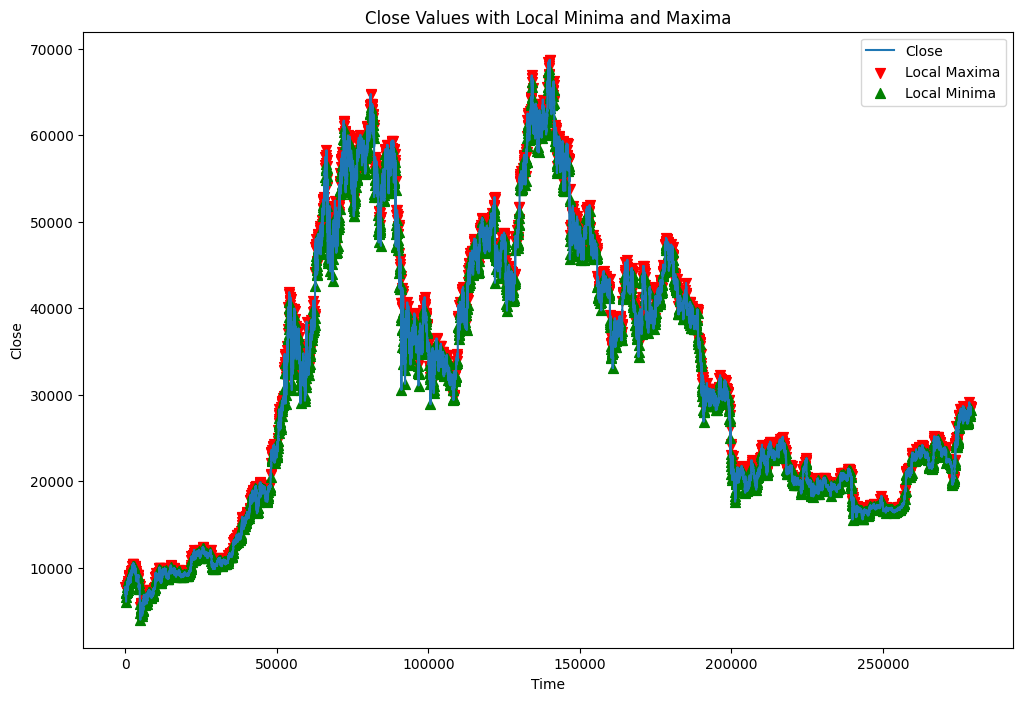

Ending Capital: 290812.58822666615
Total Theoretical Profit: 289812.58822666615
Win Percentage: 97.1604938271605%
Max Drawdown: 1212.8588668074226
Max Drawdown Percent: 0.8336795030772781
Total Trades: 3240
Average Return: 104.7802900102097
Average Return pct: 1.9547498136429293
Sharpe Ratio: 0.5392318091900089
Buy signals: 3976 Sell signals: 3924 Candles: 279014
Percent of candles with signal (buy or sell): 2.8313991412617288%

Analysis for 15-minute data with order 2:


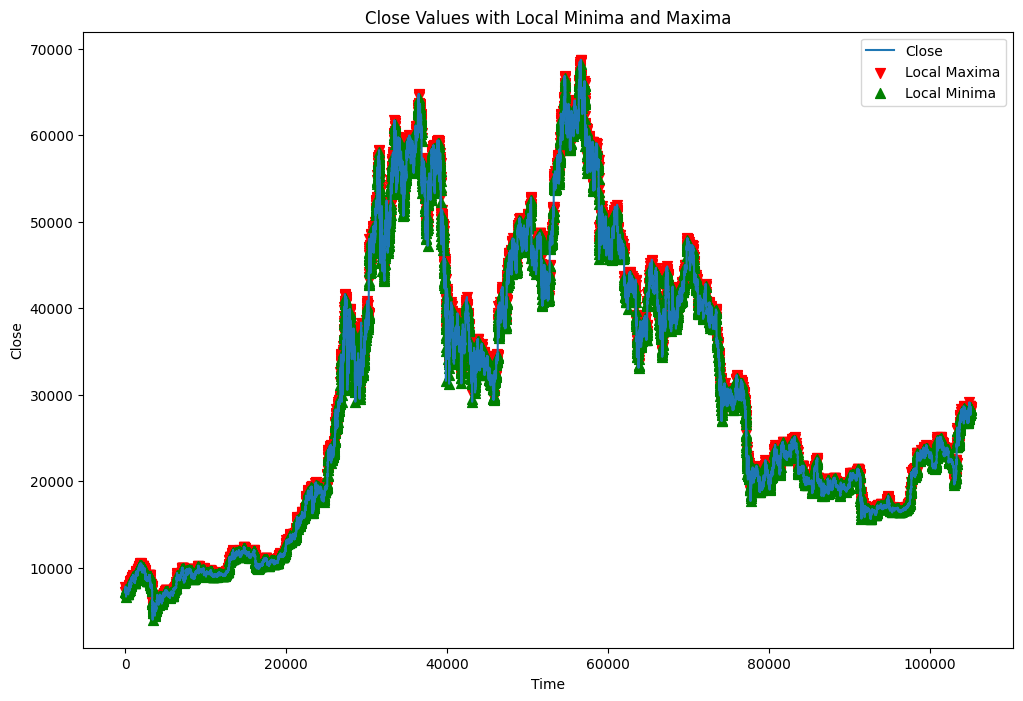

Ending Capital: 203988.5368390508
Total Theoretical Profit: 202988.5368390508
Win Percentage: 83.61731946595854%
Max Drawdown: 17397.343282189657
Max Drawdown Percent: 8.986777561969728
Total Trades: 13557
Average Return: 28.881634329727138
Average Return pct: 0.5928306737220004
Sharpe Ratio: 0.37647547550954297
Buy signals: 15707 Sell signals: 15715 Candles: 105085
Percent of candles with signal (buy or sell): 29.901508302802494%

Analysis for 15-minute data with order 6:


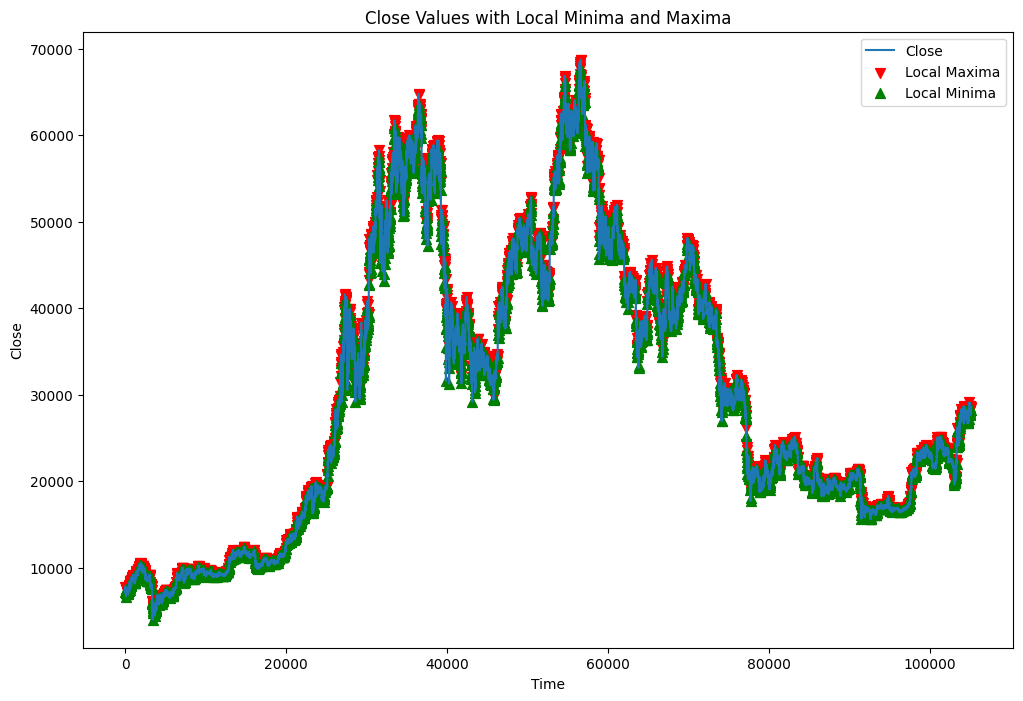

Ending Capital: 271668.66000991693
Total Theoretical Profit: 270668.66000991693
Win Percentage: 95.60462670872766%
Max Drawdown: 1359.6454218278814
Max Drawdown Percent: 0.6298238995240846
Total Trades: 4755
Average Return: 71.77726998544735
Average Return pct: 1.3809155132820863
Sharpe Ratio: 0.4976827820255768
Buy signals: 5711 Sell signals: 5679 Candles: 105085
Percent of candles with signal (buy or sell): 10.838844744730457%

Analysis for 15-minute data with order 100:


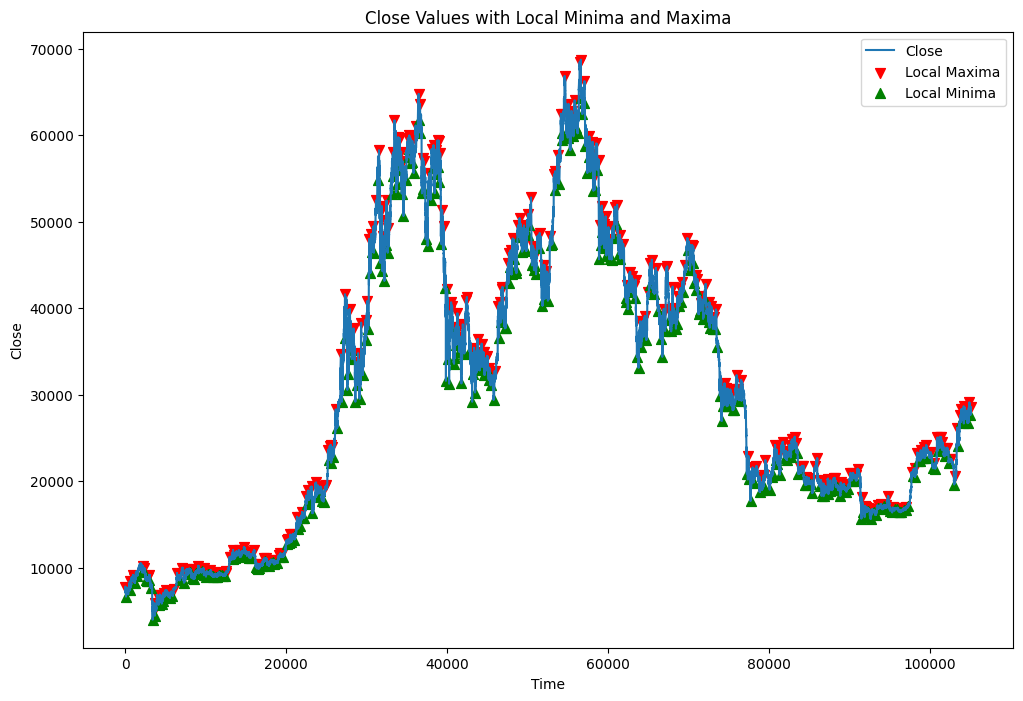

Ending Capital: 8252.756881470163
Total Theoretical Profit: 7252.756881470163
Win Percentage: 96.98996655518395%
Max Drawdown: 123.0295398041053
Max Drawdown Percent: 2.306434214822062
Total Trades: 299
Average Return: 25.044980310231672
Average Return pct: 7.306175147360117
Sharpe Ratio: 0.9794475256531947
Buy signals: 371 Sell signals: 351 Candles: 105085
Percent of candles with signal (buy or sell): 0.6870628538801923%

Analysis for 1-hour data with order 1:


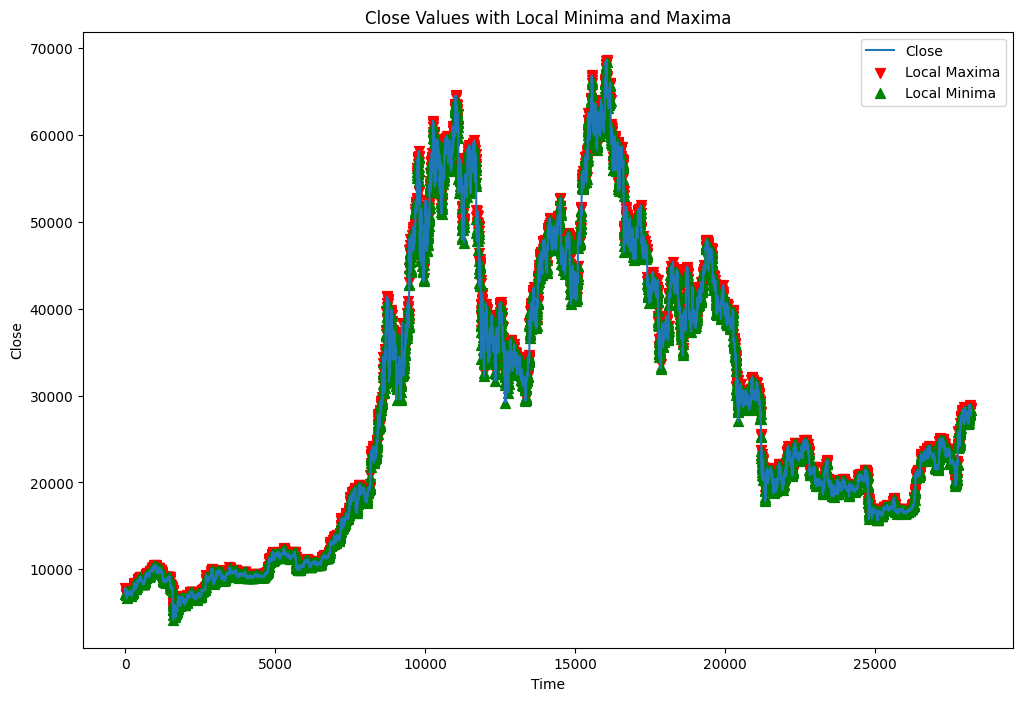

Ending Capital: 58034.19036152243
Total Theoretical Profit: 57034.19036152243
Win Percentage: 80.22960886397009%
Max Drawdown: 1535.6036545239622
Max Drawdown Percent: 3.0554531441422283
Total Trades: 7491
Average Return: 11.488908128722757
Average Return pct: 0.7430255251234414
Sharpe Ratio: 0.42044954362409315
Buy signals: 7505 Sell signals: 7503 Candles: 28216
Percent of candles with signal (buy or sell): 53.189679614403175%

Analysis for 12-hour data with order 1:


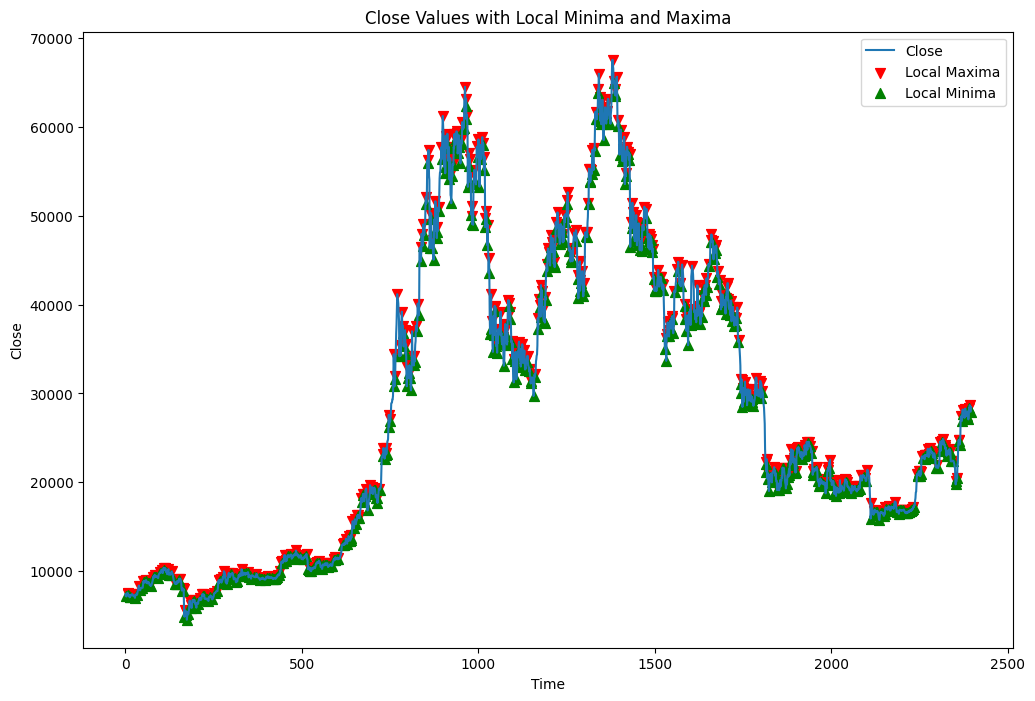

Ending Capital: 6690.1097057488205
Total Theoretical Profit: 5690.1097057488205
Win Percentage: 94.87603305785125%
Max Drawdown: 4.101240596248317
Max Drawdown Percent: 0.06229235797926558
Total Trades: 605
Average Return: 11.352707083908701
Average Return pct: 3.5307138833198772
Sharpe Ratio: 0.7305585517489043
Buy signals: 606 Sell signals: 606 Candles: 2396
Percent of candles with signal (buy or sell): 50.58430717863105%

Analysis for 1-day data with order 1:


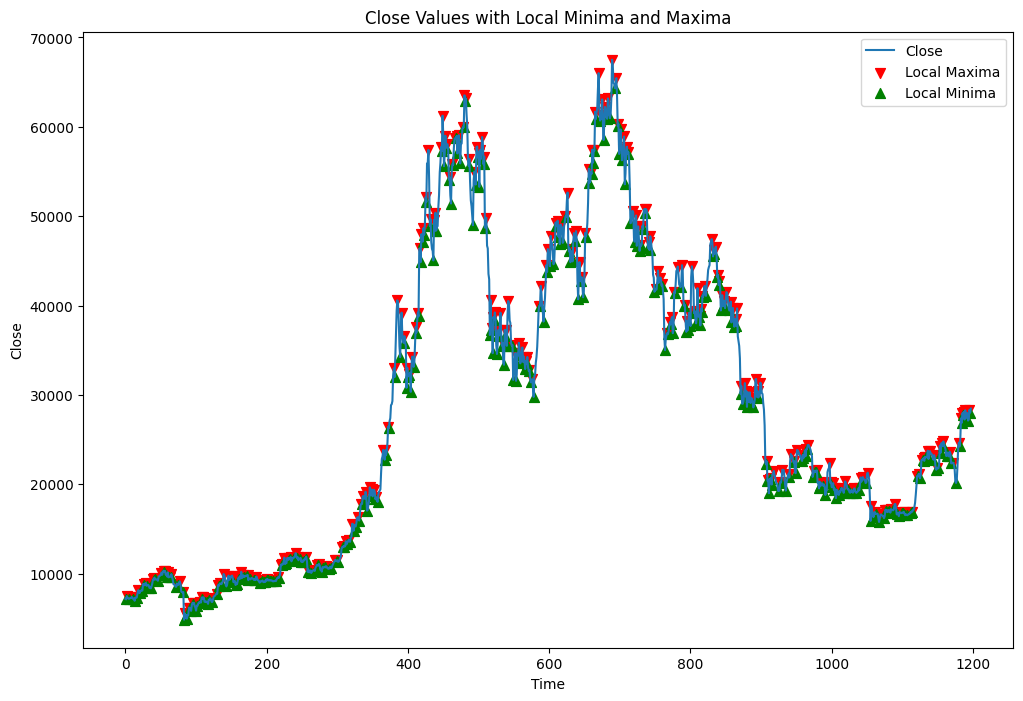

Ending Capital: 4203.59815787426
Total Theoretical Profit: 3203.5981578742603
Win Percentage: 99.09638554216868%
Max Drawdown: 1.1315814059948934
Max Drawdown Percent: 0.028641394191908365
Total Trades: 332
Average Return: 11.555855057806433
Average Return pct: 4.868139267914815
Sharpe Ratio: 0.8289103812745061
Buy signals: 333 Sell signals: 332 Candles: 1198
Percent of candles with signal (buy or sell): 55.509181969949914%



In [6]:
df_1h = pd.read_feather("/Users/dad/Desktop/Freqtrade/user_data/data/kraken/BTC_USDT-1h.feather")
df_15m = pd.read_feather("/Users/dad/Desktop/Freqtrade/user_data/data/kraken/BTC_USDT-15m.feather")
df_5m = pd.read_feather("/Users/dad/Desktop/Freqtrade/user_data/data/kraken/BTC_USDT-5m.feather")
df_12h = pd.read_feather("/Users/dad/Desktop/Freqtrade/user_data/data/kraken/BTC_USDT-12h.feather")
df_1d = pd.read_feather("/Users/dad/Desktop/Freqtrade/user_data/data/kraken/BTC_USDT-1d.feather")

analysis_params = [
    ("5-minute", df_5m[0:2000], 100),
    ("5-minute", df_5m[0:2000], 50),
    ("5-minute", df_5m, 6),
    ("5-minute", df_5m, 24),
    ("15-minute", df_15m, 2),
    ("15-minute", df_15m, 6),
    ("15-minute", df_15m, 100),
    ("1-hour", df_1h, 1),
    ("12-hour", df_12h, 1),
    ("1-day", df_1d, 1)
]

for time_frame, data, order in analysis_params:
    print(f"Analysis for {time_frame} data with order {order}:")
    profit, signal_percentage = analyze_trading_strategy(
        data, order=order, plot_flag=True, print_flag=True, investment_percentage=0.1
    )
    print()

In [7]:
from scipy import stats
import numpy as np
import pandas as pd

def apply_gaussian_filter(df, kernel_size, sigma):
    """
    Apply a Gaussian filter to the 'close' column of a DataFrame, with edge approximation.

    Parameters:
    df (pd.DataFrame): DataFrame with a 'close' column.
    kernel_size (int): Size of the Gaussian kernel (must be an odd integer).
    sigma (float): Standard deviation of the Gaussian kernel.

    Returns:
    pd.Series: Series of the smoothed 'close' values.
    """
    if 'close' not in df.columns:
        raise ValueError("DataFrame must contain a 'close' column")

    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd integer")

    # Generate Gaussian kernel
    kernel = stats.norm.pdf(np.linspace(-3*sigma, 3*sigma, kernel_size), 0, sigma)
    kernel /= np.sum(kernel)  # Normalize the kernel

    # Padding the edges
    half_size = kernel_size // 2
    extended_close = np.pad(df['close'], (half_size, half_size), 'edge')

    # Apply convolution
    smoothed = np.convolve(extended_close, kernel, mode='valid')

    return pd.Series(smoothed, index=df.index)

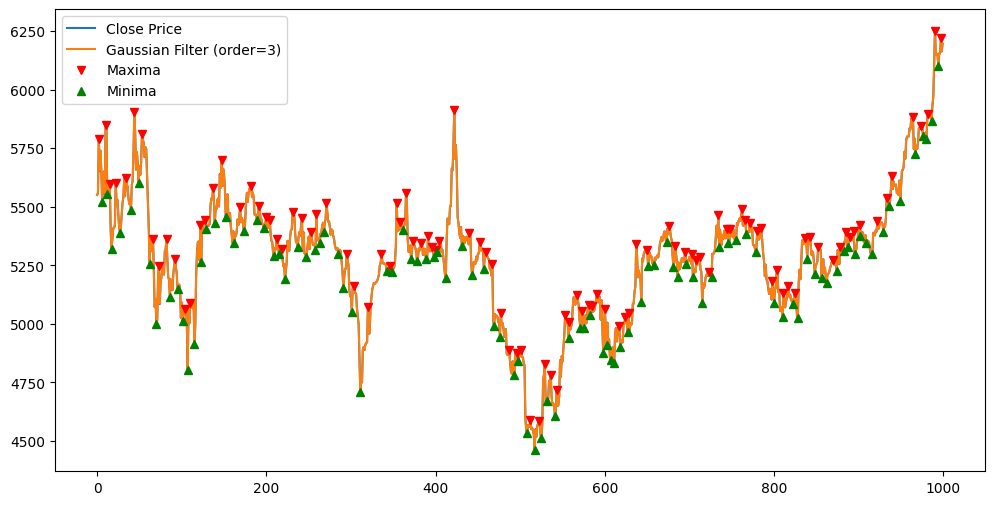

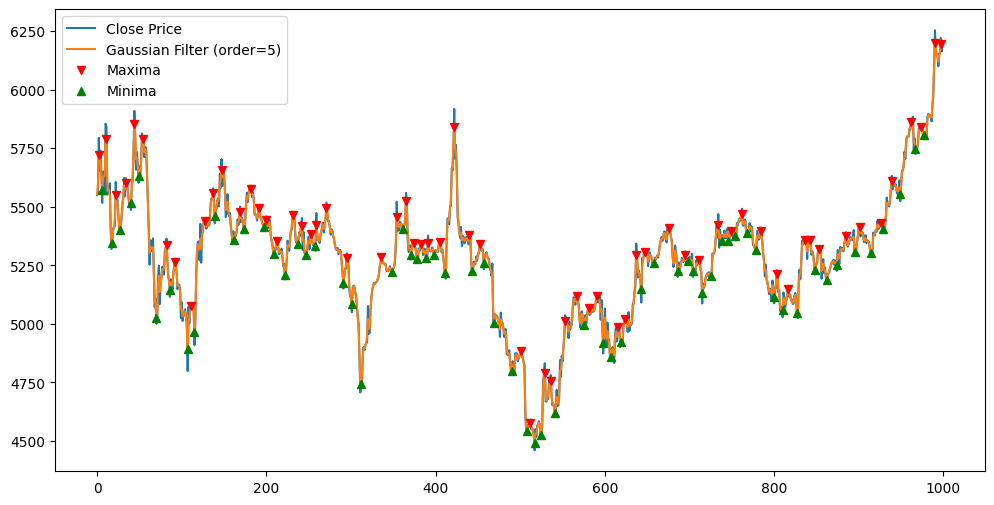

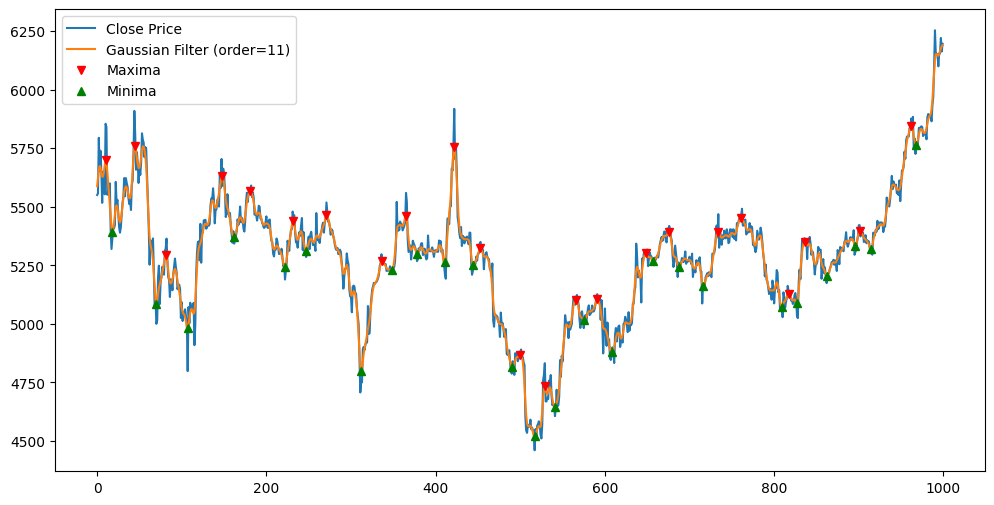

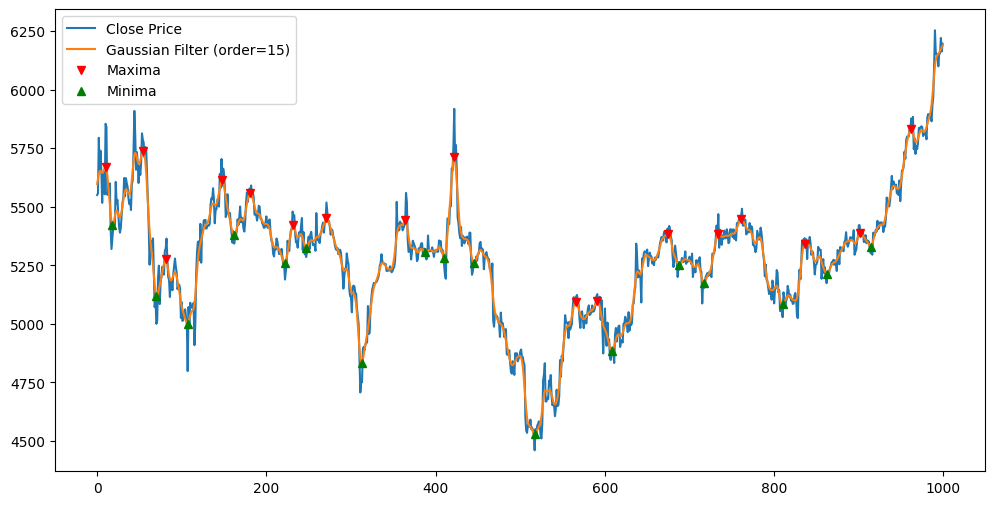

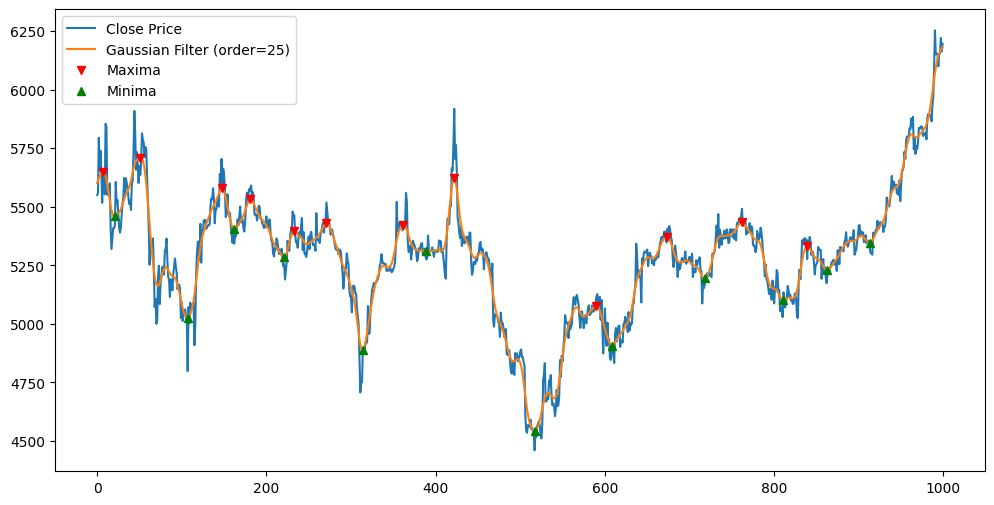

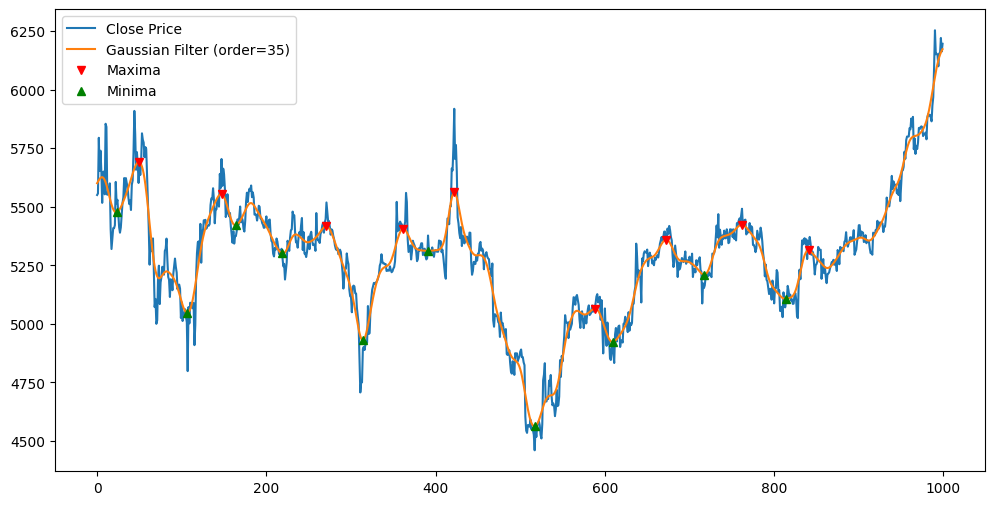

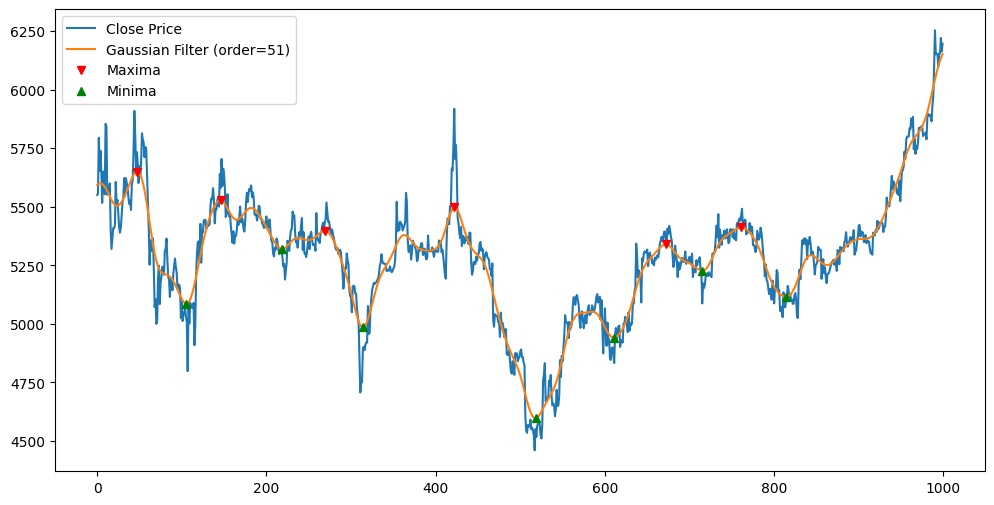

In [8]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

# Load data
df = df_5m[5000:6000].reset_index(drop=True)
close_price = df['close']

orders = [3, 5, 11, 15, 25, 35, 51]

for order in orders:
    # Apply the Gaussian filter
    gauss_close = apply_gaussian_filter(df, kernel_size=order, sigma=order/6)

    # Find local maxima and minima indices of the Gaussian filter
    maxima_indices = argrelextrema(gauss_close.values, np.greater, order=order)[0]
    minima_indices = argrelextrema(gauss_close.values, np.less, order=order)[0]

    # Create a new figure
    plt.figure(figsize=(12, 6))
    plt.plot(close_price, label='Close Price')
    plt.plot(gauss_close, label=f'Gaussian Filter (order={order})')
    plt.plot(maxima_indices, gauss_close[maxima_indices], 'rv', label='Maxima')
    plt.plot(minima_indices, gauss_close[minima_indices], 'g^', label='Minima')
    plt.legend()
    plt.show()